In [ ]:
!pip install wikipedia
!pip install spacy==2.1.0
!pip install neuralcoref --no-binary neuralcoref
!python -m spacy download en
!python -m spacy download en_core_web_sm
#restart runtime after running this cell

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.1 MB 5.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.1 MB 5.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
#Imports

%matplotlib inline

import spacy
import wikipedia
import re
import pandas as pd
import bs4
import requests
import neuralcoref
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt


In [ ]:
nlp = spacy.load('en_core_web_sm')
neuralcoref.add_to_pipe(nlp) # helps in coreference resolution

In [ ]:

text = wikipedia.summary('Paracetamol') # getting the text from the 'paracetamol' wikipage
doc = nlp(text) # creating the spacy object
print(doc)


Paracetamol,  also known as acetaminophen, is a medication used to treat fever and mild to moderate pain. Common brand names include Tylenol and Panadol.
At a standard dose, paracetamol only slightly decreases body temperature; it is inferior to ibuprofen in that respect, and the benefits of its use for fever are unclear. Paracetamol may relieve pain in acute mild migraine but only slightly in episodic tension headache. However, the aspirin/paracetamol/caffeine combination helps with both conditions where the pain is mild and is recommended as a first-line treatment for them. Paracetamol is effective for post-surgical pain, but it is inferior to ibuprofen. The paracetamol/ibuprofen combination provides further increase in potency and is superior to either drug alone. The pain relief paracetamol provides in osteoarthritis is small and clinically insignificant. The evidence in its favor for the use in low back pain, cancer pain, and neuropathic pain is insufficient.In the short term, com

In [ ]:
# coreference resolution
resolved_text = doc._.coref_resolved
print(resolved_text) # as you can see, all the pronouns have been converted to the entity closest to it. This is done so that we don't get pronouns as separate entities. 

Paracetamol,  also known as acetaminophen, is a medication used to treat fever and mild to moderate pain. Common brand names include Tylenol and Panadol.
At a standard dose, paracetamol only slightly decreases body temperature; paracetamol is inferior to ibuprofen in that respect, and the benefits of paracetamol use for fever are unclear. Paracetamol may relieve pain in acute mild migraine but only slightly in episodic tension headache. However, the aspirin/paracetamol/caffeine combination helps with both conditions where the pain is mild and is recommended as a first-line treatment for them. Paracetamol is effective for post-surgical pain, but Paracetamol is inferior to ibuprofen. the aspirin/paracetamol/caffeine combination provides further increase in potency and is superior to either drug alone. Paracetamol provides in osteoarthritis is small and clinically insignificant. The evidence in its favor for the use in low back pain, cancer pain, and neuropathic pain is insufficient.In th

In [ ]:
# Part-of-speech tagging and printing the dependency of each word

for tok in nlp(resolved_text):
  print(tok.text, "->", tok.dep_ , tok.pos_)

Paracetamol -> nsubj PROPN
, -> punct PUNCT
  ->  SPACE
also -> advmod ADV
known -> parataxis VERB
as -> prep ADP
acetaminophen -> pobj NOUN
, -> punct PUNCT
is -> ROOT VERB
a -> det DET
medication -> attr NOUN
used -> acl VERB
to -> aux PART
treat -> xcomp VERB
fever -> dobj NOUN
and -> cc CCONJ
mild -> conj ADJ
to -> aux PART
moderate -> advcl VERB
pain -> dobj NOUN
. -> punct PUNCT
Common -> amod ADJ
brand -> compound NOUN
names -> nsubj NOUN
include -> ROOT VERB
Tylenol -> dobj PROPN
and -> cc CCONJ
Panadol -> conj PROPN
. -> punct PUNCT

 ->  SPACE
At -> prep ADP
a -> det DET
standard -> amod ADJ
dose -> pobj NOUN
, -> punct PUNCT
paracetamol -> nsubj NOUN
only -> advmod ADV
slightly -> advmod ADV
decreases -> ccomp VERB
body -> compound NOUN
temperature -> dobj NOUN
; -> punct PUNCT
paracetamol -> nsubj NOUN
is -> ROOT VERB
inferior -> acomp ADJ
to -> aux PART
ibuprofen -> xcomp VERB
in -> prep ADP
that -> det DET
respect -> pobj NOUN
, -> punct PUNCT
and -> cc CCONJ
the -> det D

In [ ]:
# Function for extracting the entity pairs (subject and object) from the text
# Idea is to go through a sentence and extract the subject and the object as they appear 
# However, an entity can span across multiple words, eg: “10-year-old"
# Therefore, extract the subject/object along with its modifiers and also extract the punctuation marks between them
# Here, we are assuming there's only one subject/object pair in a sentence and hence returning only a single pair

def extract_entity_pair(sent):
  
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""
 
  for tok in nlp(sent):
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check if token is a modifier or not
      if tok.dep_.endswith("mod") == True and tok.dep_ != 'advmod':
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      # subject word
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      # object word
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  
  return [ent1.strip(), ent2.strip()]

In [ ]:
from nltk import tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# splitting the raw text into sentences
sentences = tokenize.sent_tokenize(resolved_text)
print(sentences)

['Paracetamol,  also known as acetaminophen, is a medication used to treat fever and mild to moderate pain.', 'Common brand names include Tylenol and Panadol.', 'At a standard dose, paracetamol only slightly decreases body temperature; paracetamol is inferior to ibuprofen in that respect, and the benefits of paracetamol use for fever are unclear.', 'Paracetamol may relieve pain in acute mild migraine but only slightly in episodic tension headache.', 'However, the aspirin/paracetamol/caffeine combination helps with both conditions where the pain is mild and is recommended as a first-line treatment for them.', 'Paracetamol is effective for post-surgical pain, but Paracetamol is inferior to ibuprofen.', 'the aspirin/paracetamol/caffeine combination provides further increase in potency and is superior to either drug alone.', 'Paracetamol provides in osteoarthritis is small and clinically insignificant.', 'The evidence in its favor for the use in low back pain, cancer pain, and neuropathic 

In [ ]:
entity_pairs = []

for i in sentences:
  entity_pairs.append(extract_entity_pair(i))

print(entity_pairs)

[['Paracetamol', 'moderate  pain'], ['Common brand names', 'Tylenol'], ['benefits', 'paracetamol fever'], ['Paracetamol', 'episodic tension headache'], ['pain', 'first line them'], ['surgical  Paracetamol', 'surgical  pain'], ['paracetamol caffeine combination', 'further  drug'], ['provides', 'osteoarthritis'], ['it', 'tolerability'], ['Chronic  consumption', 'gastrointestinal hemoglobin bleeding'], ['', 'higher  paracetamol'], ['consistent  association', 'developing  hypertension'], ['is', 'true  increase'], ['daily research dose', 'adult'], ['Higher  doses', 'liver failure'], ['most New Paracetamol', '1877'], ['Paracetamol', 'used United States'], ['It', 'Essential Medicines'], ['Paracetamol', 'generic brand others'], ['Paracetamol', '4 million 4 prescriptions']]


In [ ]:
# function to extract relationships between the entity pairs
# Idea is to extract all the words having dependency tag as 'ROOT'

def extract_relation(sent):

  doc = nlp(sent)

  matcher = Matcher(nlp.vocab) # Creating a Matcher class object 

  # define the pattern for pattern matching - spacy rule based matching
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  #pattern=[{'POS': 'VERB', 'OP': '?'},
  #{'POS': 'ADV', 'OP': '*'},
  #{'OP': '*'}, 
  #{'POS': 'VERB', 'OP': '+'}]

  
  matcher.add("match_the_dep",  None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
relations = [extract_relation(i) for i in sentences]
print(relations)

['is', 'include', 'is inferior', 'relieve', 'helps with', 'is effective', 'provides further', 'is small', 'are', 'result in', 'is', 'increase', 'observed in', 'is', 'lead to', 'made in', 'is', 'is on', 'is available', 'was']


In [ ]:
# subject
source = [i[0] for i in entity_pairs]

# object
target = [i[1] for i in entity_pairs]


kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df # printing the SVO triplets


,source,target,edge
0,Paracetamol,moderate pain,is
1,Common brand names,Tylenol,include
2,benefits,paracetamol fever,is inferior
3,Paracetamol,episodic tension headache,relieve
4,pain,first line them,helps with
5,surgical Paracetamol,surgical pain,is effective
6,paracetamol caffeine combination,further drug,provides further
7,provides,osteoarthritis,is small
8,it,tolerability,are
9,Chronic consumption,gastrointestinal hemoglobin bleeding,result in


In [ ]:
list_of_svo_triplets = []

for index, row in kg_df.iterrows():
  temp_list = []
  list_of_svo_triplets.append([row["source"], row["edge"], row["target"] ])

print(list_of_svo_triplets)
  

[['Paracetamol', 'is', 'moderate  pain'], ['Common brand names', 'include', 'Tylenol'], ['benefits', 'is inferior', 'paracetamol fever'], ['Paracetamol', 'relieve', 'episodic tension headache'], ['pain', 'helps with', 'first line them'], ['surgical  Paracetamol', 'is effective', 'surgical  pain'], ['paracetamol caffeine combination', 'provides further', 'further  drug'], ['provides', 'is small', 'osteoarthritis'], ['it', 'are', 'tolerability'], ['Chronic  consumption', 'result in', 'gastrointestinal hemoglobin bleeding'], ['', 'is', 'higher  paracetamol'], ['consistent  association', 'increase', 'developing  hypertension'], ['is', 'observed in', 'true  increase'], ['daily research dose', 'is', 'adult'], ['Higher  doses', 'lead to', 'liver failure'], ['most New Paracetamol', 'made in', '1877'], ['Paracetamol', 'is', 'used United States'], ['It', 'is on', 'Essential Medicines'], ['Paracetamol', 'is available', 'generic brand others'], ['Paracetamol', 'was', '4 million 4 prescriptions']]


In [ ]:
edges_dict = {}
for index, row in kg_df.iterrows():
    edges_dict[(row["source"], row["target"])] =row["edge"]

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

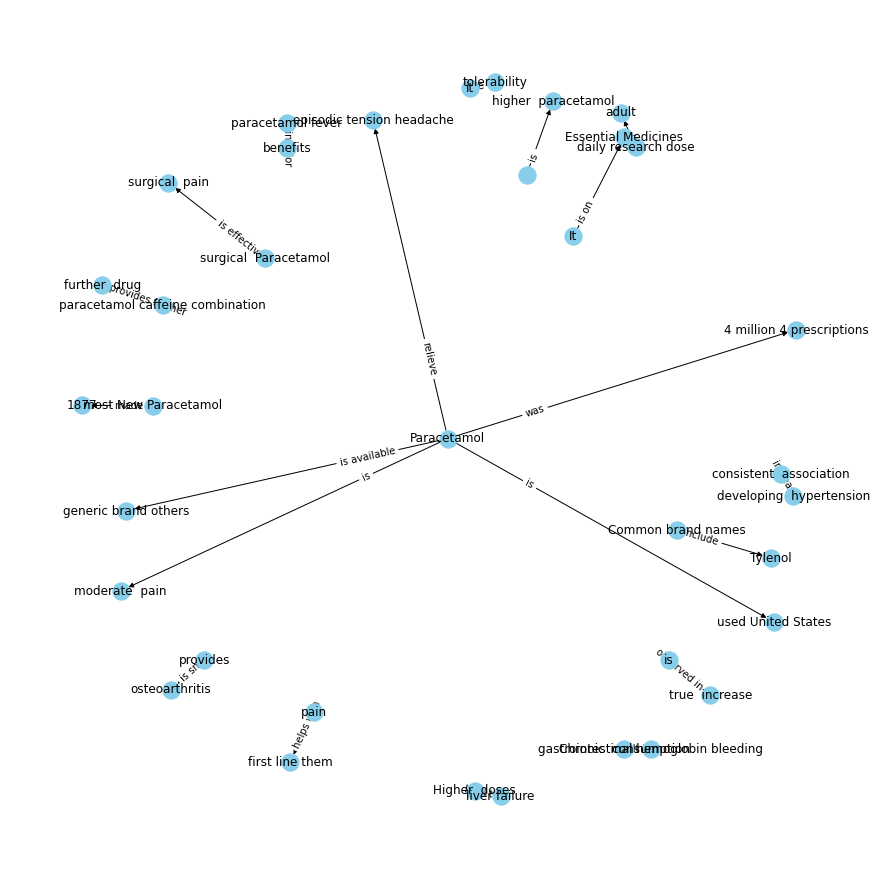

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)

nx.draw_networkx_edge_labels(G, pos,
                              edges_dict,
                              label_pos=0.75
                              )
plt.show()

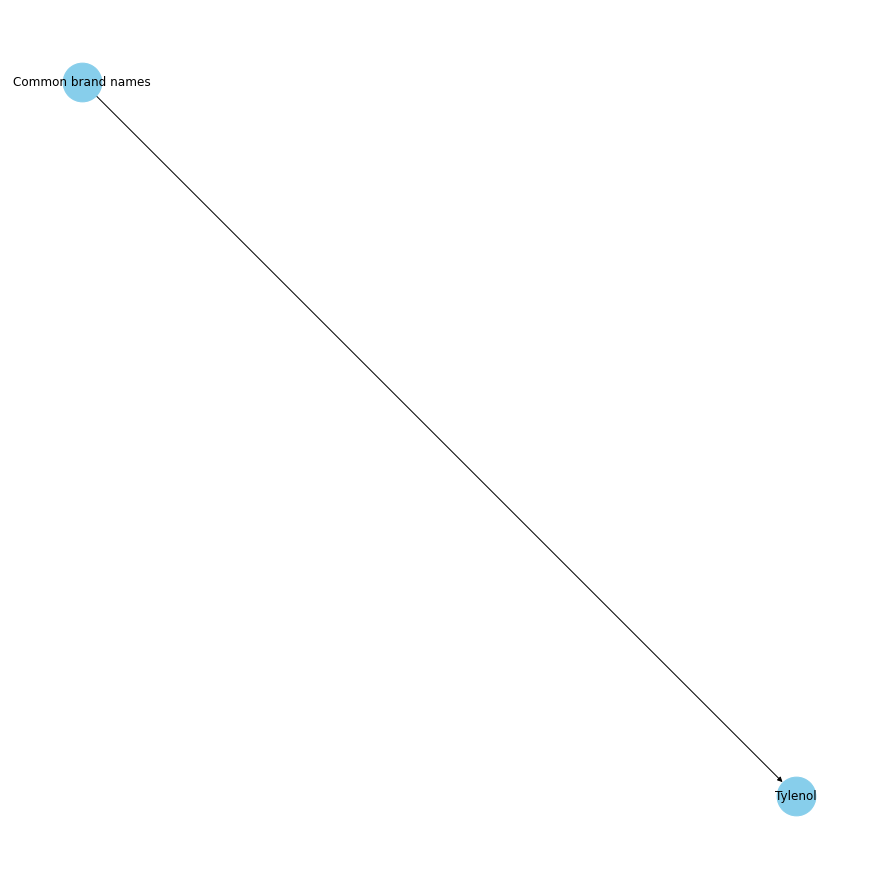

In [ ]:
# printing only a particular relationship

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="include"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()